In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
sess = tf.Session(config=config)
set_session(sess)

from scipy.spatial import distance

Using TensorFlow backend.


In [2]:
from keras.models import load_model
base_model = load_model('base_model.h5')

d:\visualstudio\shared\python36_64\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
from Feature_reader import *
from TripletGenerator import *
test_reader = Feature_reader(3, r"D:\VoxCeleb\test")
test_triplet_generator = TripletGenerator(test_reader)

In [4]:
from metrics import *

def get_random_output(m, reader, Id):
    fft = reader.get_ids_random_feature(Id)
    prediction = m.predict(fft.reshape(1, fft.shape[0], fft.shape[1], 1))
    reshaped = np.squeeze(prediction)
    return reshaped

def count_unsimilariry(m, reader, classes_count, class_realizations_count):
    
    Ids = set([random.choice(reader.ids) for _ in range(classes_count)])
    realizations = []
    for Id in Ids:
        realizations.append([get_random_output(m, reader, Id) for _ in range(class_realizations_count)])
                           
    return (mean_cos_unsimilarity(realizations, internal = True), mean_cos_unsimilarity(realizations, internal = False))

In [5]:
import random
import numpy as np

def verification(reader, pois, limit = 4715):
    
    ids = random.sample(reader.ids, pois)
    realizations = {Id: [] for Id in ids}
    
    for _ in range(limit):
        Id = random.choice(ids)
        feature = reader.get_ids_random_feature(Id)
        suitable_feature = feature.reshape(1, feature.shape[0], feature.shape[1], 1)
        embedding = np.squeeze(base_model.predict(suitable_feature))
        realizations[Id].append(embedding)
    
    realizations = [np.asarray(realizations[key]) for key in realizations]
    
    return realizations
    

In [6]:
db = verification(test_reader, 40)

In [7]:
def AreSame(first, second, margin):
    dist = distance.cdist(first, second, 'cosine')
    return dist < margin

def get_FAR_and_FRR(first, second, margin):
    
    far = np.mean(AreSame(first, second, margin))
    
    frr1 = 1 - np.mean(AreSame(first, first, margin))
    frr2 = 1 - np.mean(AreSame(second, second, margin))
    
    frr = (frr1 + frr2) / 2
    
    return far, frr

In [8]:
x_axe = []

fars = []
frrs = []

for margin in np.linspace(0, 1, 50):

    far = []
    frr = []
    for index1 in range(0, len(db)):
        for index2 in range(index1 + 1, len(db)):
            _far, _frr = get_FAR_and_FRR(db[index1], db[index2], margin)
            
            far.append(_far)
            frr.append(_frr)
    
    frrs.append(np.mean(frr))
    fars.append(np.mean(far))
    x_axe.append(margin)

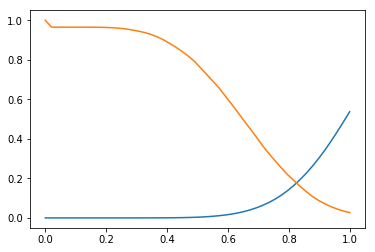

In [15]:
import matplotlib.pyplot as plt
plt.plot(x_axe, fars, label = 'False Acceptance Rate')
plt.plot(x_axe, frrs, label = 'False Rejection Rate')
plt.show()

In [136]:
def classification_rate(realizations, i):
    def i_nearest_rate(i, vector, positive, negative):
        best_positive = [(True, x) for x in sorted(np.squeeze(distance.cdist(vector.reshape(1, -1), positive)))[:i]]
        best_negative = [(False, x) for x in sorted(np.squeeze(distance.cdist(vector.reshape(1, -1), negative)))[:i]]
        
        correct = [x[0] for x in sorted(best_positive + best_negative, key = lambda x: x[1])][:i]
        
        return np.any(correct)
    
    corrects = []
    
    for classNumber in range(len(realizations)):
        for realizationNumber in range(len(realizations[classNumber])):
            vector = realizations[classNumber][realizationNumber]
                        
            positive = np.concatenate((realizations[classNumber][:realizationNumber], realizations[classNumber][realizationNumber + 1:]), axis = 0)
            negative = np.asarray([e for sublist in realizations[:classNumber] + realizations[classNumber + 1:] for e in sublist])
            
            corrects.append(i_nearest_rate(i, vector, positive, negative) )
            
    return np.mean(corrects)

In [137]:
print(classification_rate(db, 1))
print(classification_rate(db, 5))

0.9522799575821845
0.9785790031813362


In [135]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, None, 1)      0         
_________________________________________________________________
pad1 (ZeroPadding2D)         (None, 514, None, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 254, None, 96)     4800      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 254, None, 96)     384       
_________________________________________________________________
relu1 (Activation)           (None, 254, None, 96)     0         
_________________________________________________________________
mpool1 (MaxPooling2D)        (None, 126, None, 96)     0         
_________________________________________________________________
pad2 (ZeroPadding2D)         (None, 128, None, 96)     0         
__________

In [ ]:
db[0]